In [1]:
import glob
import cv2
import os.path as path
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [2]:
def read_image(path):
    bgr = cv2.imread(path)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def read_dataset(data_path):
    pattern = '**/*.png'
    files  = glob.glob(path.join(data_path, pattern))
    return [read_image(fn) for fn in files]

cars = read_dataset('./data/vehicles')
non_cars = read_dataset('./data/non-vehicles')

print("Cars dataset size: ", len(cars))
print("Non-cars dataset size: ", len(non_cars))

Cars dataset size:  8792
Non-cars dataset size:  8968


# Feature extractor

In [105]:
from skimage.feature import hog 

def get_hog_features(image, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    return hog(image, 
               orientations=orient,
               pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block),
               visualise=vis, 
               feature_vector=feature_vec)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def plot_histogram(image, nbins=32, bins_range=(0, 256), title=''):
    ch1h, ch2h, ch3h, bincen, feature_vec = ColorHistOp(image, nbins=nbins, bins_range=bins_range).perform().output()

    # Plot a figure with all three bar charts
    if ch1h is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bincen, ch1h[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch1 Histogram')
        plt.subplot(132)
        plt.bar(bincen, ch2h[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch2 Histogram')
        plt.subplot(133)
        plt.bar(bincen, ch3h[0])
        plt.xlim(0, 256)
        plt.title(title+' Ch3 Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def search_windows(img, windows, clf):
    X_pred = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        X_pred.append(test_img)
    predictions = clf.predict(np.array(X_pred))
    return [window for window, prediction in zip(windows, predictions) if prediction == 1]


# Train-test split

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

cars_train, cars_test = train_test_split(cars, test_size=0.1, random_state=0)
non_cars_train, non_cars_test = train_test_split(non_cars, test_size=0.1, random_state=0)

print("Samples in training dataset: ", len(cars_train) + len(non_cars_train))
print("Samples in test dataset: ", len(cars_test) + len(non_cars_test))


Samples in training dataset:  15983
Samples in test dataset:  1777


# Train SVM classifier

In [5]:
X_train = np.concatenate((cars_train, non_cars_train))
y_train = np.concatenate([np.ones(len(cars_train)), np.zeros(len(non_cars_train))])

In [39]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC


class HogExtractor:
    def __init__(self, color_space='RGB', hog_channel=0, spatial_feat=False, hist_feat=False):
        self.params = {'color_space': color_space, 
                       'hog_channel': hog_channel,
                       'spatial_feat': spatial_feat,
                       'hist_feat': hist_feat}
        
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        return extract_features(X, 
                                color_space=self.params['color_space'], 
                                hog_channel=self.params['hog_channel'],
                                spatial_feat=self.params['spatial_feat'], 
                                hist_feat=self.params['hist_feat'])
    
    def get_params(self, deep=False):
        return self.params
    
    def set_params(self, **params):
        self.params.update(params)
        
classifier = Pipeline([     
                     ('hog_extractor', HogExtractor()),
                     ('scaler', StandardScaler()),
                     ('svc', LinearSVC())])

param_grid = {
    'hog_extractor__color_space': ['RGB', 'LUV', 'HLS', 'YUV', 'YCrCb'],
    'hog_extractor__hog_channel': [0, 1, 2, 'ALL'],
    'hog_extractor__spatial_feat': [False, True],
    'hog_extractor__hist_feat': [False, True]
}

search = GridSearchCV(classifier, param_grid, verbose=2, cv=ShuffleSplit(test_size=0.3, n_splits=1))
search.fit(X_train, y_train)

Fitting 1 folds for each of 80 candidates, totalling 80 fits
[CV] hog_extractor__spatial_feat=False, hog_extractor__hist_feat=False, hog_extractor__hog_channel=0, hog_extractor__color_space=RGB 
[CV]  hog_extractor__spatial_feat=False, hog_extractor__hist_feat=False, hog_extractor__hog_channel=0, hog_extractor__color_space=RGB -   4.6s
[CV] hog_extractor__spatial_feat=True, hog_extractor__hist_feat=False, hog_extractor__hog_channel=0, hog_extractor__color_space=RGB 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s


[CV]  hog_extractor__spatial_feat=True, hog_extractor__hist_feat=False, hog_extractor__hog_channel=0, hog_extractor__color_space=RGB -   4.6s
[CV] hog_extractor__spatial_feat=False, hog_extractor__hist_feat=False, hog_extractor__hog_channel=1, hog_extractor__color_space=RGB 
[CV]  hog_extractor__spatial_feat=False, hog_extractor__hist_feat=False, hog_extractor__hog_channel=1, hog_extractor__color_space=RGB -   4.7s
[CV] hog_extractor__spatial_feat=True, hog_extractor__hist_feat=False, hog_extractor__hog_channel=1, hog_extractor__color_space=RGB 
[CV]  hog_extractor__spatial_feat=True, hog_extractor__hist_feat=False, hog_extractor__hog_channel=1, hog_extractor__color_space=RGB -   5.9s
[CV] hog_extractor__spatial_feat=False, hog_extractor__hist_feat=False, hog_extractor__hog_channel=2, hog_extractor__color_space=RGB 
[CV]  hog_extractor__spatial_feat=False, hog_extractor__hist_feat=False, hog_extractor__hog_channel=2, hog_extractor__color_space=RGB -   5.1s
[CV] hog_extractor__spatial_f

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 79.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.3, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('hog_extractor', <__main__.HogExtractor object at 0x13b99c240>), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'hog_extractor__spatial_feat': [False, True], 'hog_extractor__hog_channel': [0, 1, 2, 'ALL'], 'hog_extractor__hist_feat': [False, True], 'hog_extractor__color_space': ['RGB', 'LUV', 'HLS', 'YUV', 'YCrCb']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [42]:
import pandas as pd
results = pd.DataFrame(search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.to_csv('./output_model/gridsearch_result.csv')

In [43]:
search.best_params_

{'hog_extractor__color_space': 'YCrCb',
 'hog_extractor__hist_feat': True,
 'hog_extractor__hog_channel': 'ALL',
 'hog_extractor__spatial_feat': True}

In [50]:
final_classifier = search.best_estimator_
final_classifier.fit(X_train, y_train)

Pipeline(steps=[('hog_extractor', <__main__.HogExtractor object at 0x13b99cf28>), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [53]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_test = np.concatenate((cars_test, non_cars_test))
y_test = np.concatenate([np.ones(len(cars_test)), np.zeros(len(non_cars_test))])

y_pred = final_classifier.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non-cars', 'Cars']))
print("Confusion matrix: ")
print(confusion_matrix(y_test, y_pred))
print("Final classifier score: %.4f" % final_classifier.score(X_test, y_test))


             precision    recall  f1-score   support

   Non-cars       0.99      0.99      0.99       897
       Cars       0.99      0.99      0.99       880

avg / total       0.99      0.99      0.99      1777

Confusion matrix: 
[[890   7]
 [  6 874]]
Final classifier score: 0.9927


In [54]:
from sklearn.externals import joblib
joblib.dump(final_classifier, './output_model/model.pkl')

['./output_model/model.pkl']

# Car detection in images

In [56]:
classifier = joblib.load('./output_model/model.pkl')
classifier

Pipeline(steps=[('hog_extractor', <__main__.HogExtractor object at 0x1340292e8>), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

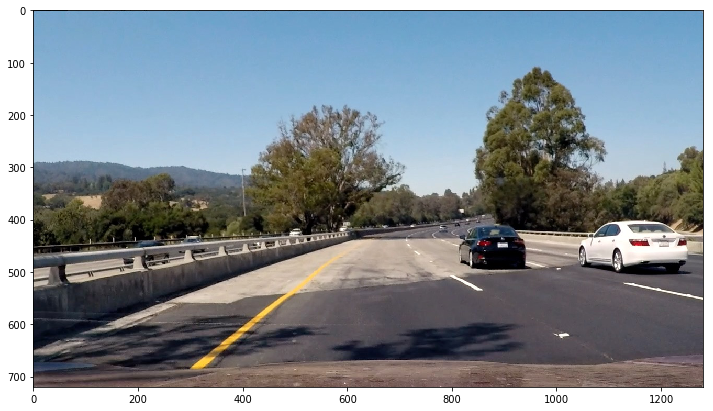

In [64]:
sample_image = read_image('./test_images/test4.jpg')
plt.figure(figsize=(12, 9))
plt.imshow(sample_image)

In [181]:
def window_with_height(height):
    return (height, height)

def detect_hot_windows(image):
    overlap = 0.9

    windows = []
    windows += slide_window(image, x_start_stop=[640, None], y_start_stop=[375, 439], 
                        xy_window=window_with_height(64), xy_overlap=(overlap, overlap)) 

    windows += slide_window(image, x_start_stop=[640, None], y_start_stop=[375, 567], 
                            xy_window=window_with_height(96), xy_overlap=(overlap, overlap)) 
    windows += slide_window(image, x_start_stop=[640, None], y_start_stop=[375, 695], 
                            xy_window=window_with_height(224), xy_overlap=(overlap, overlap))
    return search_windows(image, windows, classifier)  


def draw_detected_boxes(image):
    return draw_boxes(image, detect_hot_windows(image))

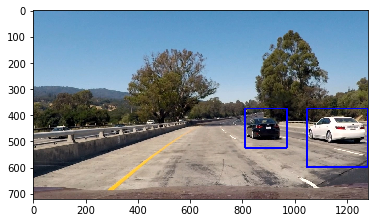

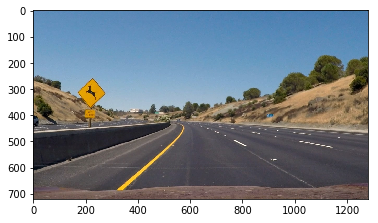

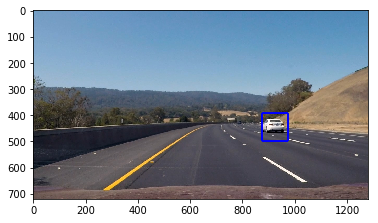

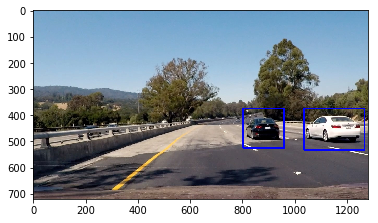

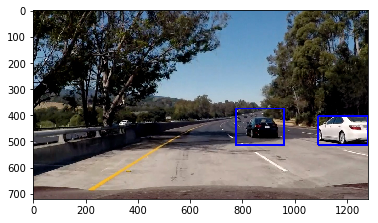

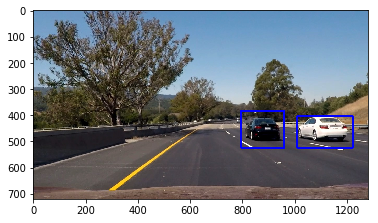

In [183]:
from scipy.ndimage.measurements import label

def detect_car_rectangles(image):
    heatmap = np.zeros(image.shape[0:2])
    hot_windows = detect_hot_windows(image)
    add_heat(heatmap, hot_windows)
    apply_threshold(heatmap, 3)
    
    labels = label(heatmap)
    return draw_labeled_bboxes(image.copy(), labels)

for imfile in glob.glob('./test_images/*.jpg'):
    image = read_image(imfile)
    plt.figure()
    
    plt.imshow(detect_car_rectangles(image))

# Video processing pipeline

In [78]:
import os.path as path
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def display_video(video_file):
    return HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_file))

def make_output_path(filename):
    basename = path.basename(filename)
    return path.join('./test_images', basename)

def process_video(filename, processor):
    clip = VideoFileClip(filename)
    processed = clip.fl_image(processor)
    
    output_file = make_output_path(filename)
    processed.write_videofile(output_file, audio=False)
    return output_file

In [184]:
def video_processor(image):
    return detect_car_rectangles(image)

output = process_video('./project_video.mp4', video_processor)

[MoviePy] >>>> Building video ./test_images/project_video.mp4
[MoviePy] Writing video ./test_images/project_video.mp4



100%|█████████▉| 1260/1261 [3:06:53<00:08,  8.81s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_images/project_video.mp4 



In [185]:
display_video(output)

In [ ]:
plt.imshow(sample_image[370:])